In [57]:
import torch
import torchvision
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader, Dataset

import jax
import jax.numpy as jnp
from jax import random

# neural networks
import flax
from flax import linen as nn
from flax.training import train_state

# optimizer
import optax

import numpy as np
import matplotlib.pyplot as plt

In [5]:
transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32)
])

train_dataset = torchvision.datasets.MNIST("mnist_train", train=True, download=True, transform=transforms)
val_dataset = torchvision.datasets.MNIST("mnist_val", train=False, download=True, transform=transforms)


100%|██████████| 9.91M/9.91M [00:00<00:00, 56.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.60MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 49.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.94MB/s]


In [7]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
      return np.array(batch)


batch_size=128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)

images, labels = next(iter(train_dataloader))

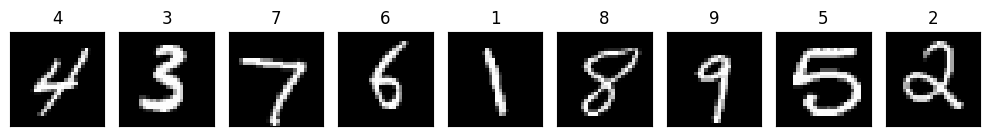

In [27]:
#visualize data
samples = torch.randperm(len(images))[:9]

fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(10,5))
for i, sample in enumerate(samples):
  axs[i].imshow(images[sample].reshape(28,28, 1), cmap='gray')
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].set_title(labels[sample])

plt.tight_layout()
plt.show()

In [50]:
## define jax model
class MnistClassifier(nn.Module):
  num_hidden_dims: int
  num_classes:int = 10

  @nn.compact
  def __call__(self, x):
    # flatten
    batch_size = x.shape[0]
    x = np.reshape(batch_size, -1)

    x = nn.Dense(self.num_hidden_dims)(x)
    x = nn.relu(x)
    x = nn.Dense(self.num_classes)(x)
    return x

model = MnistClassifier(num_hidden_dims=256)
print(model)

MnistClassifier(
    # attributes
    num_hidden_dims = 256
    num_classes = 10
)


In [51]:
rng = random.PRNGKey(42)

## initialize parameters
rng, init_rng, inp_rng = random.split(rng, num=3)
inp = random.normal(inp_rng, (batch_size, 784))

# initialize the model
params = model.init(init_rng, inp)
print(params)

{'params': {'Dense_0': {'kernel': Array([[ 0.04095885,  0.8504831 , -0.05294394,  1.9043044 ,  1.6655127 ,
        -1.0854695 , -0.9295122 , -0.59995735, -0.9804353 ,  1.15798   ,
        -0.21450247,  0.39540157,  0.3887089 , -0.38271585, -1.3223652 ,
         0.56400996, -1.1739535 ,  0.51273733,  1.5246094 ,  0.27376452,
        -0.6637842 ,  1.6261141 , -0.96264493,  0.44081745, -1.5243345 ,
         0.11633034,  1.6250155 ,  0.41284665, -0.71016026,  0.4361056 ,
        -1.434654  ,  2.064683  , -0.34034747, -0.37649915, -0.6172288 ,
         1.0169228 , -0.0631078 , -0.8836906 ,  0.7837978 , -0.73575026,
        -0.5599285 , -1.3196355 , -0.7860407 ,  1.4600959 , -0.07398083,
         0.08115043,  0.26097584, -1.8632346 ,  0.42356318, -0.79492426,
         0.7608694 ,  0.38294062, -0.9473125 , -0.04596826, -1.2313867 ,
         0.03238124, -0.30788454,  0.3811614 ,  1.4834281 ,  0.63862735,
         1.2735397 , -0.92407   ,  0.10360052, -0.00713092,  1.9926207 ,
         0.404521

In [52]:
# test model on dummy input
model.apply(params, inp).shape

(10,)

In [55]:
# setup optimizer
optimizer = optax.adam(learning_rate=1e-2)

In [59]:
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                     params=params,
                                     tx=optimizer)

In [67]:
logits = model_state.apply_fn(params, inp)
logits

Array([-12.576115, -70.50556 , -87.320854,   7.057307, -87.45896 ,
        88.54211 ,  14.15906 ,  98.62349 ,  43.898037,  50.467445],      dtype=float32)

In [73]:
def calculate_loss_accuracy(state, params, batch):
  images, labels = batch

  logits = state.apply_fn(params, images)

  # calculate loss and accuracy
  loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels.unsqueeze(0))
  acc = (labels == jnp.argmax(logits, dim=1)).mean()

  return loss, acc

In [74]:
batch = next(iter(train_dataloader))
calculate_loss_accuracy(model_state, model_state.params, batch)

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'